# 과제1_신용대출 심사_변수중요도

* 고객사는 ## 은행입니다. 신용평가 업무를 인공지능으로 전환하고자 여러분에게 모델링을 의뢰하였습니다.
* 대출업무는
    * 은행 창구에서 신청을 받고
    * 본사의 심사부서에서는 신용평가를 통해 대출 신청에 대한 승인 여부를 결정해 왔습니다.

* 현장의 요구
    * 경쟁사의 공격적인 대출상품 판매로, 본사에서는 자사 은행의 대출 실적이 줄어들고 있는 것에 부담을 느끼고 있습니다.
    * 그런데, 자사 은행에서는 신용평가 결과의 정확성에 의문을 품고 있으며, 신용평가 기준을 완화하여 가급적 대출승인 범위를 더 확대해 주기를 요구합니다.

* 신용평가 업무를 인공지능으로 전환
    * 현장의 요구를 감안하여, 과거 사람이 하던 평가방식을 개선하고자 인공지능에 의한 예측 모델을 만들고, 정확도를 높이고자 합니다.
-----------------


* 고객에게 제공한 예측 모델
    * 여러분은 다양한 알고리즘과 튜닝을 통해 모델을 생성하였습니다.
    * 모델의 정확도가 상당히 높다고 평가 되었습니다.
    * 고객은 여러분의 결과물에 대해 기뻐하고 있습니다. 그리고 한가지 질문을 해 왔습니다.
        * **"이번에 제공한 예측 모델의 정확도가 높아 상당히 만족스럽습니다. 그런데 궁금한 점이 있습니다. 모델이 신용도를 예측하는데 중요한 요인은 무엇인가요?"**

* 본 과제를 통해서 다음을 수행합니다.
    * 다양한 알고리즘으로 모델을 만들고 성능 평가하기
    * 트리 모델로 부터 변수 중요도 확인하기
    * 그 외 모델(SVM, DL 등) 변수 중요도 확인하기

## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

### 2) 필요한 함수 생성

In [2]:
# 변수 중요도 plot1
def plot_feature_importance(importance, names, topn = 'all'):

    # 변수중요도, feature 이름 정리
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # 데이터프레임으로 변환
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    # 중요도 순으로 정렬
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    # 전체? or top N?
    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    # 그래프 그리기
    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    # 정리한 변수 중요도 df return
    return fi_df

In [3]:
# 변수 중요도 plot2
def plot_PFI(pfi, col_names):
    plt.figure(figsize = (14,5))
    plt.subplot(1,2,1)
    for i,vars in enumerate(col_names) :
        sns.kdeplot(pfi.importances[i], label = vars)
    plt.legend()
    plt.grid()

    sorted_idx = pfi.importances_mean.argsort()
    plt.subplot(1,2,2)
    plt.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=col_names[sorted_idx])
    plt.axvline(0, color = 'r')
    plt.grid()
    plt.show()

### 3) 데이터 로딩

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.drop('Purpose', axis = 1, inplace = True)
data.head()

,Creditability,AccountBalance,Duration,Payment,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,1424,5,2,4,1,55,2,1,4,1,2,1


|	칼럼명	|	설명	|	 	|	값 의미	|
|	-----	|	-----	|	-----	|	-----	|
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|
|	Age	|	Age (years)	|	나이	|		|
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|
|	Telephone	|	Telephone	|	전화기 소유 여부	|	2: Yes , 1: No	|
|	ForeignWorker	|	Foreign Worker	|	외국인 근로자 여부	|	2: Yes , 1: No	|



* 데이터의 크기를 살펴봅시다.

In [5]:
data.shape

(1000, 16)

* Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


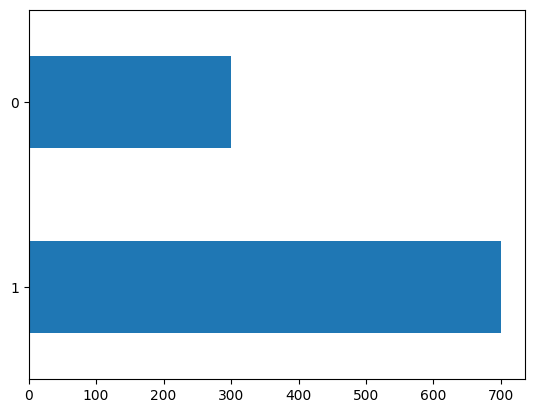

In [6]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts(normalize = True))

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

## 2.데이터 준비


### 1) x, y로 나누기

In [7]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

In [8]:
dummy_vars = ['SexMarital', 'MostValuableAsset','ForeignWorker','Telephone']

x = pd.get_dummies(x, columns = dummy_vars, drop_first = True)
x.head()

,AccountBalance,Duration,Payment,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
0,3,24,2,1249,2,2,28,2,1,3,1,0,0,1,0,0,0,0,0
1,2,9,2,276,3,4,22,1,1,2,1,0,0,1,0,0,0,0,0
2,1,18,3,1049,2,4,21,1,1,3,1,1,0,0,1,0,0,0,0
3,1,24,3,6419,5,4,44,3,2,4,2,1,0,0,0,0,1,0,1
4,3,12,2,1424,5,4,55,2,1,4,1,1,0,0,0,0,0,0,1


### 3) train : validation 분할

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)

## 3.트리 모델의 변수 중요도
* 모델 생성
    * decision tree, random forest, xgb 알고리즘을 이용하여 각각 모델을 만드시오.
    * 모델을 튜닝하시오.
* 성능 및 변수 중요도 비교
    * 성능이 가장 좋은 모델을 선정하시오.
    * 성능이 가장 좋은 모델의 변수 중요도와 그렇지 않은 모델의 변수 중요도를 비교하시오.


### 1) decision tree

### 2) random forest

In [10]:
params = {'n_estimators':[50,100,300],
          'max_depth':[3,5,7],
          }
model1 = GridSearchCV(RandomForestClassifier(), params, cv=5, verbose=1)
model1.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 300]},
             verbose=1)

### 3) xgboost

In [11]:
params = {'n_estimators':[50,100,300],
          'max_depth':[3,5,7],
          'learning_rate':[0.01,0.05,0.1,0.5,1]
          }
model2 = GridSearchCV(XGBClassifier(), params, cv=10, verbose=1)
model2.fit(x_train, y_train)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 300]},
             verbose=1)

### 4) 모델 성능 비교
* 세 모델 중 성능이 가장 좋은 모델은?

In [13]:
# randomforest
pred1 = model1.predict(x_val)
accuracy_score(y_val, pred1)

0.735

In [15]:
# xgb
pred2 = model2.predict(x_val)
accuracy_score(y_val, pred2)

0.72

* 변수 중요도 비교 : 세 모델간 변수 중요도를 비교해 봅시다.

In [16]:
model1.best_estimator_.feature_importances_

array([0.19346323, 0.15155416, 0.06187641, 0.13909626, 0.07761457,
       0.03621133, 0.1182367 , 0.03035769, 0.0220063 , 0.02889052,
       0.01731136, 0.01713529, 0.02142507, 0.00843337, 0.01192526,
       0.0177919 , 0.0250226 , 0.00609213, 0.01555585])

In [19]:
model2.best_estimator_.feature_importances_

array([0.2896409 , 0.07969874, 0.04496678, 0.04192904, 0.05057254,
       0.03347743, 0.03479027, 0.03633937, 0.03491585, 0.03093924,
       0.00709561, 0.05505391, 0.04638226, 0.        , 0.03233482,
       0.0453163 , 0.06447764, 0.03533826, 0.03673098], dtype=float32)

## 4.Permutation Feature Importance
* 변수 중요도를 제공하지 않는 모델 생성
    * SVM, KNN, DL 혹은 그외 알고리즘으로 모델을 생성하시오.
    * 알고 있는 방법을 최대한 동원하여 모델을 각각 최적화 하시오.
* 성능 및 변수 중요도 비교
    * 트리 모델과 성능 비교
    * Permutation Feature Importance 를 이용하여 변수 중요도를 뽑아 봅시다.


In [17]:
from sklearn.inspection import permutation_importance

* 스케일링

In [18]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### 1) 모델1

In [25]:
model3 = Sequential()
model3.add(Dense(256 ,activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model3.fit(x_train_s, y_train, epochs=200)

Epoch 1/200
25/25 [==============================] - 3s 4ms/step - loss: 0.5898 - accuracy: 0.7175
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 0.5307 - accuracy: 0.7163
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4978 - accuracy: 0.7625
Epoch 4/200
25/25 [==============================] - 0s 7ms/step - loss: 0.4963 - accuracy: 0.7650
Epoch 5/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4736 - accuracy: 0.7763
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4682 - accuracy: 0.7700
Epoch 7/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4584 - accuracy: 0.7812
Epoch 8/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4566 - accuracy: 0.7812
Epoch 9/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4433 - accuracy: 0.7950
Epoch 10/200
25/25 [==============================] - 0s 4ms/step - loss: 0.4289 - accuracy: 0.7962
Epoch 11/

In [24]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (32, 256)                 5120      
                                                                 
 dense_8 (Dense)             (32, 128)                 32896     
                                                                 
 dense_9 (Dense)             (32, 1)                   129       
                                                                 
Total params: 38145 (149.00 KB)
Trainable params: 38145 (149.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2) 모델2

----

* 성능비교

In [26]:
model3.evaluate(x_val_s, y_val)

7/7 [==============================] - 0s 8ms/step - loss: 2.7143 - accuracy: 0.7000


[2.714257001876831, 0.699999988079071]

## 5.모델저장
* joblib을 이용하여 선정한 모델을 저장합니다.

In [ ]:
import joblib

joblib.dump(     , 'model.pkl')